In [4]:
import jax

jax.config.update("jax_enable_x64", True)

import galsim

import numpy as np
import jax.numpy as jnp
import jax_galsim.core.interpolate

In [5]:
import matplotlib.pyplot as plt

## Define Range of Interpolant and Spacings

In [137]:
beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 100  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 100  # we build this many rational function approximations
RATNL_ORDER = 11

betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

# this is the function we are interpolating
def _fun(beta, sr, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=sr
    ).withGSParams(maxk_threshold=mkt).maxk

## Build rational function apprx. in beta at fixed maxk_threshold

In [138]:
import scipy.optimize
import numpy.polynomial
from numpy.polynomial import Polynomial

numpy.polynomial.set_default_printstyle("ascii")


def get_ratnl_func_polys(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)
    return pm, qm


def get_ratnl_func_coeffs(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    return p_coeff, q_coeff


def ratnl_func(x, *coeff):
    pm, qm = get_ratnl_func_polys(coeff)
    return pm(x) / qm(x)


def make_poly_code(pm, head="", base_indent=0):
    res = ""
    indent = base_indent
    for c in pm.coef:
        if c == pm.coef[-1]:
            end = ""
        else:
            end = " + x * ("

        if c == pm.coef[0]:
            _hd = head
        else:
            _hd = ""
        res += " " * 4 * indent + f"{_hd}{c}{end}\n"
        if c != pm.coef[-1]:
            indent += 1

    for _ in pm.coef[:-1]:
        indent -= 1
        res += " " * 4 * indent + ")\n"

    return res

In [139]:
eps = 1e-6

poly_res = []

for mkt in mkts:
    vals = np.array([_fun(beta, 1.0, mkt) for beta in betas])

    res = scipy.optimize.curve_fit(
        ratnl_func,
        np.log(betas),
        np.log(vals),
        p0=np.ones(2 * RATNL_ORDER + 1),
        full_output=True,
        maxfev=100000,
        ftol=eps,
        xtol=eps,
    )

    coeff = res[0]

    pm, qm = get_ratnl_func_coeffs(coeff)

    poly_res.append((pm[::-1], qm[::-1]))

In [140]:
import textwrap

pstr = textwrap.indent(
    np.array2string(np.array(poly_res), floatmode="unique", threshold=100000000, separator=", ", max_line_width=120, sign="+"),
    "    ",
)

In [141]:
code = f"""\
# START OF GENERATED CODE
# The code in this block is generated by the notebook dev/notebooks/moffat_maxk_interp.ipynb.

MKTS_MIN = {mkts_min}
MKTS_MAX = {mkts_max}
N_MKTS = {n_mkts}
LOG_MKTS = np.log(np.logspace(jnp.log10(MKTS_MIN), jnp.log10(MKTS_MAX), N_MKTS))

# RATIONAL_POLY_VALS is an array of 7-th order ration function approximations
# for maxk as a function of log(beta) at fixed maxk_threshold values. the coeffs
# are stored from highest degree to lowest. The shape of the array is
# ({n_mkts}, 2, {RATNL_ORDER + 1}).
# fmt: off
RATIONAL_POLY_VALS = np.array(
{pstr},
    dtype=np.float64,
)
# fmt: on


@jax.jit
def _moffat_maxk(beta, maxk_threshold, r0):
    log_beta = jnp.log(beta)
    log_maxk_threshold = jnp.log(maxk_threshold)
    maxk_vals = jnp.array(
        [
            jnp.exp(
                jnp.polyval(RATIONAL_POLY_VALS[i, 0, :], log_beta)
                / jnp.polyval(RATIONAL_POLY_VALS[i, 1, :], log_beta)
            )
            for i in range(N_MKTS)
        ]
    )
    coeffs = akima_interp_coeffs(LOG_MKTS, maxk_vals)
    return akima_interp(log_maxk_threshold, LOG_MKTS, maxk_vals, coeffs) / r0


# END OF GENERATED CODE
"""

print(code)

# START OF GENERATED CODE
# The code in this block is generated by the notebook dev/notebooks/moffat_maxk_interp.ipynb.

MKTS_MIN = 1e-12
MKTS_MAX = 0.1
N_MKTS = 100
LOG_MKTS = np.log(np.logspace(jnp.log10(MKTS_MIN), jnp.log10(MKTS_MAX), N_MKTS))

# RATIONAL_POLY_VALS is an array of 7-th order ration function approximations
# for maxk as a function of log(beta) at fixed maxk_threshold values. the coeffs
# are stored from highest degree to lowest. The shape of the array is
# (100, 2, 12).
# fmt: off
RATIONAL_POLY_VALS = np.array(
    [[[+7.2856203345679582e-01, -1.0357132045828534e+00, +2.1836451389513154e+01, -1.0028162998171847e+01,
       +1.9443583994149163e+00, -1.5879198962467733e+01, +1.0232049755455938e+01, -8.5161654592562499e+00,
       -1.8055241893516651e+01, -6.6375749906494633e+01, +5.4305391296598863e+01, +3.1101813072427702e+00],
      [+5.2777109179077415e-02, +1.8724922626233054e-01, +4.2975008926878742e+00, +1.9576590347926566e+00,
       -5.9278486667880426e+00, +1.0

## Testing

In [142]:
from jax_galsim.core.interpolate import akima_interp, akima_interp_coeffs

exec(code)

In [6]:
rng = np.random.default_rng(seed=10)
n_test = 100000

betas = rng.uniform(low=1.1 + 1e-6, high=100, size=n_test)
maxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
apprx = np.array([
    _moffat_maxk(betas[i], maxk_thresholds[i], 1.0)
    for i in range(n_test)
])
true = np.array([
    _fun(betas[i], 1.0, maxk_thresholds[i])
    for i in range(n_test)
])

# plt.hist(true / apprx - 1, bins=25, log=True)
# ax = plt.gca()
# ax.set_xlabel("fractional error in maxk approx.")
# ax.set_ylabel("# of points")

fig, ax = plt.subplots()
hb = ax.hexbin(
    betas,
    np.log10(maxk_thresholds),
    C=np.log10(np.abs(apprx-true)),
    extent=(1.1, 100, -12, -1),
    gridsize=50,
    vmin=-7,
    vmax=-2
)
ax.set_xlim(1.1, 100)
ax.set_ylim(-12, -1)
ax.set_xlabel("beta")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label="log10(|approx - true|)")

NameError: name '_moffat_maxk' is not defined

# Pseudo-Pade Approx

In [9]:
from functools import partial

import optax

orders = [7, 11]
lval = 2
n0 = orders[0] * 2 - 1
n1 = orders[1]
n_params = n0 * n1

beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 50  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 50  # we build this many rational function approximations

max_opt_num = 16  # n_beta * n_mkts // 10
print(f"minimizing worst {max_opt_num} points")


def _pseudo_pade_one(coeffs, order, x):
    p = jnp.polyval(coeffs[:order], x)
    return p
    # q = jnp.polyval(
    #     jnp.concatenate([coeffs[order:], jnp.ones(1)], axis=0),
    #     x,
    # )
    # return p / q


def _pseudo_pade_zero(coeffs, order, x):
    p = jnp.polyval(coeffs[:order], x)
    q = jnp.polyval(
        jnp.concatenate([coeffs[order:], jnp.ones(1)], axis=0),
        x,
    )
    return p / q


@jax.jit
@partial(jax.vmap, in_axes=(0, 0, None))
def _lnmaxk_fun(lnb, lnmkt, coeffs):
    coeffs = coeffs.reshape(n0, n1)
    pqvals = jax.vmap(_pseudo_pade_one, in_axes=(0, None, None))(coeffs, orders[1], lnb)
    return _pseudo_pade_zero(pqvals, orders[0], lnmkt)
    # pvals = pqvals[:orders[0]]
    # qvals = pqvals[orders[0]:]
    # qvals = jnp.concatenate([qvals, jnp.ones(1)], axis=0)
    # return (
    #     jnp.polyval(pvals, lnmkt)
    #     /
    #     jnp.polyval(qvals, lnmkt)
    # )

    # pvals = []
    # qvals = []
    # for i in range(orders[0]):
    #     pvals.append(
    #         jnp.polyval(coeffs[i, :orders[1]], lnb)
    #         /
    #         jnp.polyval(
    #             jnp.concatenate([coeffs[i, orders[1]:], jnp.ones(1)], axis=0),
    #             lnb,
    #         )
    #     )
    #     if i < orders[0] - 1:
    #         qvals.append(
    #             jnp.polyval(coeffs[i + orders[0], :orders[1]], lnb)
    #             /
    #             jnp.polyval(
    #                 jnp.concatenate([coeffs[i + orders[0], orders[1]:], jnp.ones(1)], axis=0),
    #                 lnb,
    #             )
    #         )
    # pvals = jnp.array(pvals)
    # qvals = jnp.array(qvals)
    # qvals = jnp.concatenate([qvals, jnp.ones(1)], axis=0)
    # return (
    #     jnp.polyval(pvals, lnmkt)
    #     /
    #     jnp.polyval(qvals, lnmkt)
    # )


@jax.jit
def _loss(coeffs, lnbetas, lnmaxk_thresholds, lnmaxks):
    pvals = _lnmaxk_fun(lnbetas, lnmaxk_thresholds, coeffs)
    return jnp.mean(jnp.sort((pvals - lnmaxks)**lval)[-max_opt_num:])
    # return jnp.max((pvals - lnmaxks)**lval)


# this is the function we are interpolating
def _fun(beta, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=1.0
    ).withGSParams(maxk_threshold=mkt).maxk


_betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
_mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

betas = []
mkts = []
maxks = []
for beta in _betas:
    for mkt in _mkts:
        betas.append(beta)
        mkts.append(mkt)
        maxks.append(
            _fun(beta, mkt)
        )
betas = jnp.array(betas)
mkts = jnp.array(mkts)
maxks = jnp.array(maxks)

_vag_loss = jax.jit(jax.value_and_grad(_loss))

# if "coeffs" not in globals() or coeffs.shape[0] != n_params:
coeffs = jnp.ones(n_params) / jnp.power(np.prod(orders), 0.25)
assert coeffs.shape[0] == n_params
optimizer = None
learning_rate = 1e-3
opt_attr = "adan"

minimizing worst 16 points


In [29]:
import tqdm

if optimizer is None:
    optimizer = getattr(optax, opt_attr)(learning_rate)
    opt_state = optimizer.init(coeffs)

    @jax.jit
    def _update_func(coeffs, opt_state):
        loss, grads = _vag_loss(coeffs, lnb, lnmkts, lnmaxks)
        updates, opt_state = optimizer.update(grads, opt_state, params=coeffs)
        coeffs = optax.apply_updates(coeffs, updates)
        return coeffs, opt_state, loss

lnb = jnp.log(betas)
lnmkts = jnp.log(mkts)
lnmaxks = jnp.log(maxks)

prev_loss = None
n_epoch = 100_000
ditr = 1000

with tqdm.trange(n_epoch) as pbar:
    for i in pbar:
        coeffs, opt_state, loss = _update_func(coeffs, opt_state)

        if i % ditr == 0:
            if prev_loss is not None:
                dloss = (jnp.power(loss, 1 / lval) - jnp.power(prev_loss, 1 / lval))
                pbar.set_description(f"loss: {jnp.power(loss, 1 / lval):10.4e} ({dloss:+9.2e} delta)")
            else:
                pbar.set_description(f"loss: {jnp.power(loss, 1 / lval):10.4e} (--------- delta)")

            prev_loss = loss

print(f"{i:04d}: {jnp.power(loss, 1 / lval):10.4e}", flush=True)

loss: 2.9138e-03 (-7.28e-04 delta): 100%|██████████| 100000/100000 [01:09<00:00, 1428.79it/s]

99999: 3.0673e-03


0.007020591773158502
0.003496329064715087


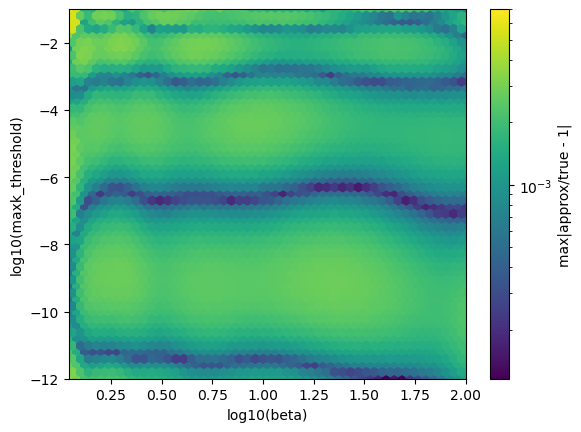

In [31]:
import numpy as np

rng = np.random.default_rng()
n_test = 100000

tbetas = 10**rng.uniform(low=np.log10(1.1 + 1e-6), high=np.log10(100), size=n_test)
tmaxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
apprx = jnp.exp(_lnmaxk_fun(jnp.log(tbetas), jnp.log(tmaxk_thresholds), coeffs))
true = np.array([
    _fun(tbetas[i], tmaxk_thresholds[i])
    for i in range(n_test)
])
eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx/true - 1|"
print(c_func(eps))

msk = tmaxk_thresholds <= 0.01
print(c_func(eps[msk]))

# plt.hist(true / apprx - 1, bins=25, log=True)
# ax = plt.gca()
# ax.set_xlabel("fractional error in maxk approx.")
# ax.set_ylabel("# of points")

fig, ax = plt.subplots()
hb = ax.hexbin(
    np.log10(tbetas),
    np.log10(tmaxk_thresholds),
    C=eps,
    reduce_C_function=c_func,
    extent=(np.log10(1.1), np.log10(100), -12, -1),
    gridsize=50,
    bins="log",
)
ax.set_xlim(np.log10(1.1), np.log10(100))
ax.set_ylim(-12, -1)
ax.set_xlabel("log10(beta)")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label=eps_label)

## Interpolation

In [21]:
# this is the function we are interpolating
def _fun(beta, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=1.0
    ).withGSParams(maxk_threshold=mkt).maxk


beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 500  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 200  # we build this many rational function approximations

_betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
_mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

betas = []
mkts = []
maxks = []
for beta in _betas:
    for mkt in _mkts:
        betas.append(beta)
        mkts.append(mkt)
        maxks.append(
            _fun(beta, mkt)
        )
betas = jnp.array(betas)
mkts = jnp.array(mkts)
maxks = jnp.array(maxks)

7.380595839612258e-05
3.918579556394519e-05


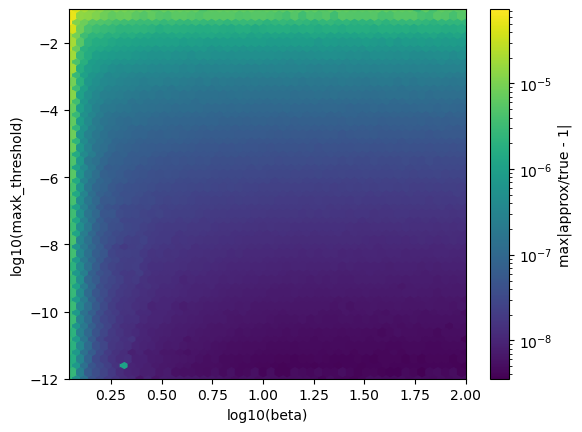

In [22]:
import interpax

rng = np.random.default_rng()
n_test = 100000

tbetas = 10**rng.uniform(low=np.log10(1.1 + 1e-6), high=np.log10(100), size=n_test)
tmaxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
apprx = jnp.exp(
    interpax.interp2d(
        jnp.log(tbetas),
        jnp.log(tmaxk_thresholds),
        jnp.log(_betas),
        jnp.log(_mkts),
        jnp.log(maxks).reshape(n_beta, n_mkts),
        method="akima"
    )
)
true = np.array([
    _fun(tbetas[i], tmaxk_thresholds[i])
    for i in range(n_test)
])
eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx/true - 1|"
print(c_func(eps))

msk = tmaxk_thresholds <= 0.03
print(c_func(eps[msk]))
# plt.hist(true / apprx - 1, bins=25, log=True)
# ax = plt.gca()
# ax.set_xlabel("fractional error in maxk approx.")
# ax.set_ylabel("# of points")

fig, ax = plt.subplots()
hb = ax.hexbin(
    np.log10(tbetas),
    np.log10(tmaxk_thresholds),
    C=eps,
    reduce_C_function=c_func,
    extent=(np.log10(1.1), np.log10(100), -12, -1),
    gridsize=50,
    bins="log",
)
ax.set_xlim(np.log10(1.1), np.log10(100))
ax.set_ylim(-12, -1)
ax.set_xlabel("log10(beta)")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label=eps_label)

## Symbolic Regression

In [ ]:
# this is the function we are interpolating
def _fun(beta, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=1.0
    ).withGSParams(maxk_threshold=mkt).maxk


beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 50  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 50  # we build this many rational function approximations

_betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
_mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

betas = []
mkts = []
maxks = []
for beta in _betas:
    for mkt in _mkts:
        betas.append(beta)
        mkts.append(mkt)
        maxks.append(
            _fun(beta, mkt)
        )
betas = jnp.array(betas)
mkts = jnp.array(mkts)
maxks = jnp.array(maxks)


In [ ]:
from pysr import PySRRegressor

X = np.stack([np.log(betas), np.log(mkts)], axis=1)
y = np.log(maxks)

model = PySRRegressor(
    maxsize=50,
    niterations=100,
    binary_operators=["+", "*", "/", "^"],
    constraints={'^': (-1, 1)},
    elementwise_loss="loss(prediction, target) = abs(prediction - target)",
    model_selection='accuracy',
)

model.fit(X, y)

In [ ]:
rng = np.random.default_rng()
n_test = 100000

tbetas = 10**rng.uniform(low=np.log10(1.1 + 1e-6), high=np.log10(100), size=n_test)
tmaxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
tX = np.stack([np.log(tbetas), np.log(tmaxk_thresholds)], axis=1)

apprx = np.exp(model.predict(tX))
true = np.array([
    _fun(tbetas[i], tmaxk_thresholds[i])
    for i in range(n_test)
])
eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx/true - 1|"
print(c_func(eps))

fig, ax = plt.subplots()
hb = ax.hexbin(
    np.log10(tbetas),
    np.log10(tmaxk_thresholds),
    C=eps,
    reduce_C_function=c_func,
    extent=(np.log10(1.1), np.log10(100), -12, -1),
    gridsize=50,
    bins="log",
)
ax.set_xlim(np.log10(1.1), np.log10(100))
ax.set_ylim(-12, -1)
ax.set_xlabel("log10(beta)")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label=eps_label)

In [ ]:
x = jnp.log(_betas * 1.01)
y = jnp.ones_like(x) * jnp.log(1e-4)
true = jnp.array([
    _fun(jnp.exp(x[i]), jnp.exp(y[i]))
    for i in range(x.shape[0])
])

approx = (
    interpax.interp2d(
        x,
        y,
        jnp.log(_betas),
        jnp.log(_mkts),
        jnp.log(maxks).reshape(n_beta, n_mkts),
        method="akima"
    )
)

plt.plot(
    x,
    approx,
)
plt.plot(
    x,
    jnp.log(true),
)

# plt.plot(x, jnp.log(true))

In [ ]:
interpax.interp2d?